In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import deque, defaultdict
from linearApprox import *
from collections import deque

In [ ]:
def run_n_step_sarsa_linear(
    initialEdges, goalEdges, totalSteps, nLookahead,
    epsilon, gamma, alpha, pGen, pSwap, maxAge,
    edr_window_size=100, convergence_epsilon=0.001, plot=False
):
    feature_size = len(initialEdges) + len(goalEdges)
    Q = LinearQApproximator(feature_size=feature_size)
    q_value_diffs = []

    goal_success_queues = {goal: deque(maxlen=edr_window_size) for goal in goalEdges}
    raw_state = [(edge, -1) for edge in initialEdges]
    rolling_edrs = {goal: 0.0 for goal in goalEdges}
    current_state = get_augmented_state(raw_state, rolling_edrs, goal_order=goalEdges)

    print("\nStarting n-step SARSA (Linear Approximation)...")

    # Initialize first action properly (not dummy)
    features = featurize_state(current_state, goal_order=goalEdges)
    possible_actions = getPossibleActions(current_state[0], goalEdges)
    action = random.choice(possible_actions) if random.random() < epsilon else max(
        possible_actions, key=lambda a: Q.get_q_value(features, a)
    )

    # Buffers for n-step SARSA
    state_buffer = deque([current_state], maxlen=nLookahead + 1)
    action_buffer = deque([action], maxlen=nLookahead + 1)
    reward_buffer = deque([], maxlen=nLookahead)

    for t in range(totalSteps):
        # Environment step
        prev_state = state_buffer[-1]
        prev_action = action_buffer[-1]

        next_state = performAction(prev_action, prev_state)
        next_state = ageEntanglements(next_state, maxAge)
        next_state = generateEntanglement(next_state, pGen)

        # Determine success for reward calculation
        consumed_edges, goal = prev_action
        success = False
        if goal is not None and consumed_edges:
            success_prob = pSwap ** (len(consumed_edges) - 1)
            success = random.random() < success_prob

        # Get reward
        reward = getReward(prev_action, goal_success_queues, t + 1, pSwap, success=success)
        reward_buffer.append(reward)

        # Update goal success queues
        for g in goal_success_queues:
            goal_success_queues[g].append(0)
        if goal is not None and consumed_edges and success:
            goal_success_queues[goal][-1] = 1

        # Compute EDR snapshot for augmentation
        edr_snapshot = {
            g: sum(goal_success_queues[g]) / max(1, len(goal_success_queues[g]))
            for g in goalEdges
        }
        next_state = get_augmented_state(next_state[0], edr_snapshot, goal_order=goalEdges)
        state_buffer.append(next_state)

        # Select next action
        next_features = featurize_state(next_state, goal_order=goalEdges)
        next_possible_actions = getPossibleActions(next_state[0], goalEdges)
        next_action = (
            random.choice(next_possible_actions)
            if random.random() < epsilon
            else max(next_possible_actions, key=lambda a: Q.get_q_value(next_features, a))
        )
        action_buffer.append(next_action)

        # Perform n-step update
        if t >= nLookahead:
            G = sum((gamma ** i) * reward_buffer[i] for i in range(nLookahead))
            s_tau = state_buffer[0]
            a_tau = action_buffer[0]
            s_next = state_buffer[-1]
            a_next = action_buffer[-1]
            G += (gamma ** nLookahead) * Q.get_q_value(featurize_state(s_next, goalEdges), a_next)

            features_tau = featurize_state(s_tau, goal_order=goalEdges)
            current_q = Q.get_q_value(features_tau, a_tau)
            Q.update(features_tau, a_tau, G, alpha)
            q_value_diffs.append(abs(G - current_q))

    # Final updates for remaining transitions
    T = len(reward_buffer)
    for t_rem in range(T):
        n = T - t_rem
        G = sum((gamma ** i) * reward_buffer[t_rem + i] for i in range(n))
        s_tau = state_buffer[t_rem]
        a_tau = action_buffer[t_rem]
        s_next = state_buffer[-1]
        a_next = action_buffer[-1]
        G += (gamma ** n) * Q.get_q_value(featurize_state(s_next, goal_order=goalEdges), a_next)

        features_tau = featurize_state(s_tau, goal_order=goalEdges)
        current_q = Q.get_q_value(features_tau, a_tau)
        Q.update(features_tau, a_tau, G, alpha)
        q_value_diffs.append(abs(G - current_q))

    return current_state, Q, edr_snapshot

In [4]:
def train_sarsa_linear_policy(
    edges, goal_edges, p_swap, p_gen, max_age,
    totalSteps, nLookahead, epsilon, gamma, alpha,
    edr_window_size=100, seed=0):
    
    random.seed(seed)
    np.random.seed(seed)

    _, Q, _ = run_n_step_sarsa_linear(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        epsilon=epsilon,
        gamma=gamma,
        alpha=alpha,
        pGen=p_gen,
        pSwap=p_swap,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        plot=False
    )
    return Q


Starting n-step SARSA (Linear) run...


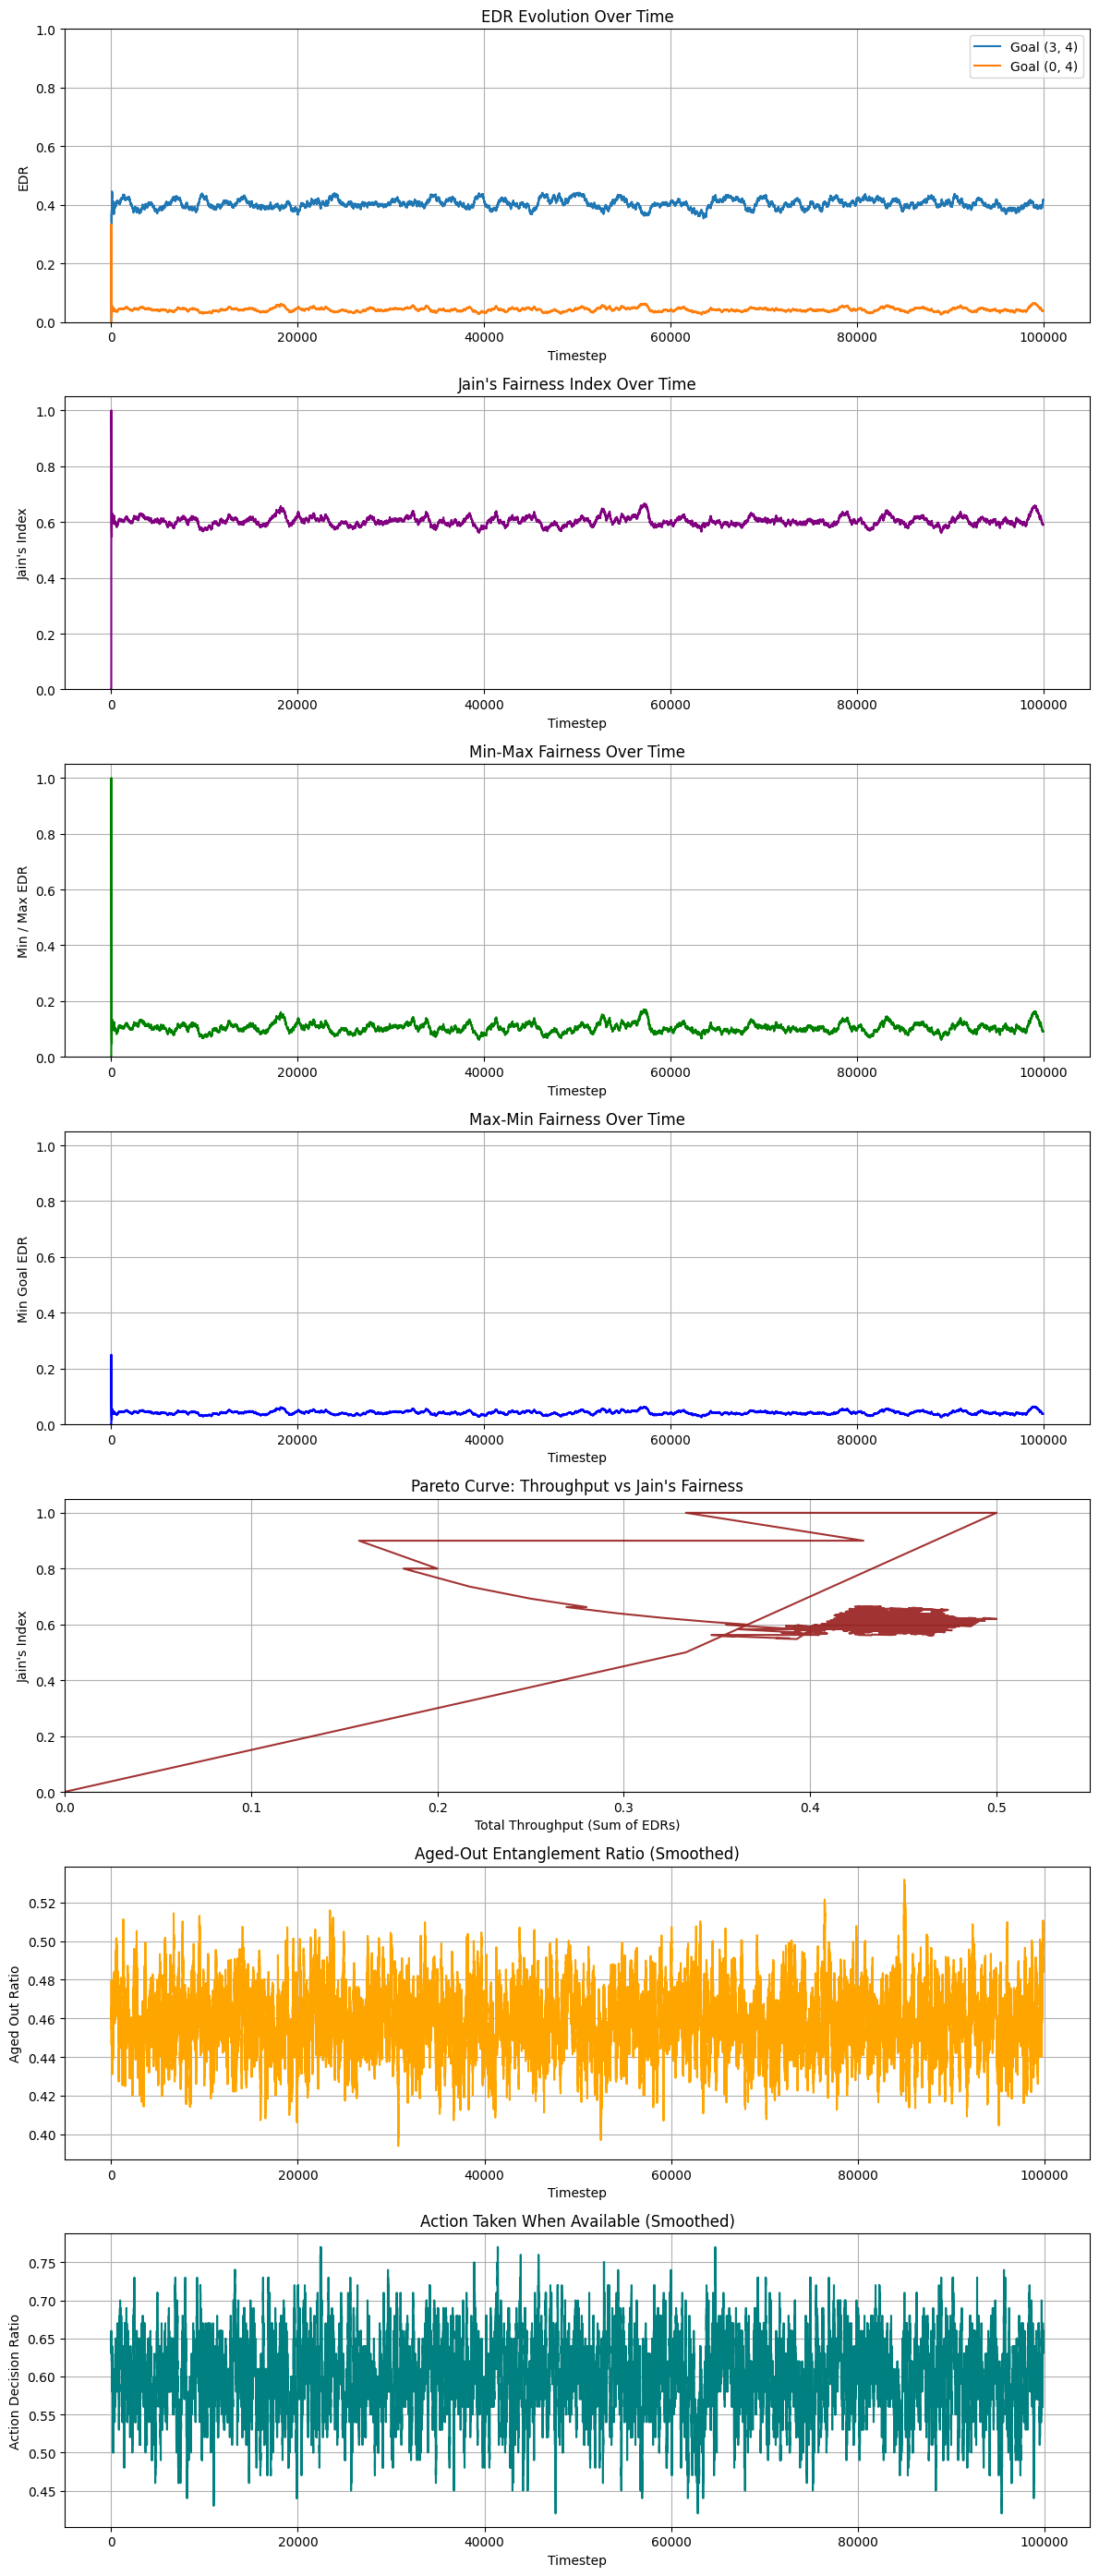

({(3, 4): 40360, (0, 4): 4201},
 100000,
 {(3, 4): [0.0,
   0.0,
   0.0,
   0.25,
   0.2,
   0.16666666666666666,
   0.2857142857142857,
   0.25,
   0.2222222222222222,
   0.2,
   0.18181818181818182,
   0.16666666666666666,
   0.15384615384615385,
   0.14285714285714285,
   0.13333333333333333,
   0.125,
   0.11764705882352941,
   0.1111111111111111,
   0.10526315789473684,
   0.15,
   0.14285714285714285,
   0.13636363636363635,
   0.17391304347826086,
   0.20833333333333334,
   0.24,
   0.23076923076923078,
   0.25925925925925924,
   0.2857142857142857,
   0.3103448275862069,
   0.3333333333333333,
   0.3225806451612903,
   0.34375,
   0.36363636363636365,
   0.35294117647058826,
   0.34285714285714286,
   0.3333333333333333,
   0.35135135135135137,
   0.3684210526315789,
   0.358974358974359,
   0.375,
   0.36585365853658536,
   0.38095238095238093,
   0.37209302325581395,
   0.36363636363636365,
   0.35555555555555557,
   0.34782608695652173,
   0.3404255319148936,
   0.3333333333

In [18]:
edges = [(0, 1), (1,2), (2,3), (3,4)]
goal_edges = [(0, 2), (1, 4)]
pSwap = 0.6
pGen = 0.6
maxAge = 2
totalSteps = 1000000
nLookahead = 2
epsilon = 0.3
gamma = 0.99
alpha = 0.2
edr_window_size=1000


_, Q, _ = run_n_step_sarsa_linear(
    initialEdges=edges,
    goalEdges=goalEdges,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    epsilon=epsilon,
    gamma=gamma,
    alpha=alpha,
    pGen=pGen,
    pSwap=pSwap,
    maxAge=maxAge,
    edr_window_size=edr_window_size,
    plot=False
)

simulate_policy(Q_table=Q, edges=edges, goal_edges=goalEdges,
                p_swap=pSwap, p_gen=pGen, max_age=maxAge,
                num_steps=100000, edr_window_size=edr_window_size, plot=True)
